In [1]:
on_line = False

if on_line:
    from epics import PV
    from GetTbTData import GetTbTData

import numpy as np
import pandas as pd

from tbt_bpm import tbt_bpm_class
from time import sleep

X_, Y_, Z_ = [0, 1, 2]

In [2]:
def meas_chrom(f_rf_pvs, bpm_name, n_steps, f_RF_step, alpha_c, n_point, cut):
    file_name = "test_tbt_data.hdf"
    
    tbt_bpm = tbt_bpm_class()
    
    # Init the BPMs for Tbt data.
    if on_line:
        tbt_io = GetTbTData(bpm_name)
    else:
        tbt_df = pd.read_hdf(file_name, key="df")
        tbt_bpm.get_tbt_df(tbt_df, n_point, cut)

    # Init PVs for master clock.
    if on_line:
        f_rf_get = PV(f_rf_pvs[0])
        f_rf_put = PV(f_rf_pvs[1])    
    
    # Skip initial transient.
    #cut, n_data = [9999, 2**10]
    
    # Store initial f_rf setpoint.
    if on_line:
        f_0_RF = f_rf_get.get()
    else:
        f_0_RF = 500e3
    print("\nmeas_chrom:\n  f_0_RF [MHz] = {:10.6f}".format(1e-3*f_0_RF))

    nu = np.zeros((2, n_steps))
    delta = np.zeros(n_steps)
    df_RF = -n_steps//2*f_RF_step
    print("\n        f_RF      delta   nu_x    nu_y")
    print("        [MHz]      [%]")
    
    for k in range(0, n_steps):
        df_RF += f_RF_step
        f_RF = f_0_RF + df_RF
        
        # Change RF frequency.
        #f_rf_put.put(f_RF)
        delta[k] = df_RF/(f_0_RF*alpha_c)
        
        # Read TbT data.
        if on_line:
            tbt_df = tbt_io.getTbTdata()
            if False:
                # Save BPM data to file.
                tbt_df.to_hdf(file_name, key="df")
        
        # Analyse TbT data.
        print()
        tbt_bpm.analyse_tbt_bpm_data(1, True, False, False)
        nu[X_][k] = tbt_bpm._f[X_, 0] + 1e0*delta[k]
        nu[Y_][k] = tbt_bpm._f[Y_, 0] - 1e0*delta[k]
        
        print("  {:2d} {:10.6f} {:8.5f} {:7.5f} {:7.5f}".
            format(k-n_steps, 1e-3*f_RF, 1e2*delta[k], nu[X_][k],
                    nu[Y_][k]))

        if on_line:
            sleep(1)

    n_pol = 2
    pol = np.zeros((2, n_pol+1))
    for k in range(2):
        pol[k] = np.polyfit(delta, nu[k, :], n_pol)
    print("\n  ksi = [{:9.3e}, {:9.3e}]".format(pol[X_][1], pol[Y_][1]))

    # Restore initial f_rf setpoint.
    if on_line:
        f_rf_put.put(f_0_RF)
    
    return [delta, nu, pol]


In [3]:
# Main program.

# Unit for RF frequency is [kHz].
f_rf_get_pv = 'MCLKHX251C:hwRdFreq'
f_rf_put_pv = 'MCLKHX251C:freq'
f_rf_pvs    = [f_rf_get_pv, f_rf_put_pv]
bpm_name    = ['BPMZ5D8R']

n_steps   = 5
f_RF_step = 0.1
alpha_c   = 7.038e-04
n_point   = 300
cut       = 108

if on_line:
    f_rf_get = PV(f_rf_get_pv)
    f_0_RF = f_rf_get.get()
else:
    f_0_RF = 500e3
print("f_RF [MHz] = {:8.6f}".format(1e-3*f_0_RF))

f_RF [MHz] = 500.000000


In [4]:
delta, nu, pol = meas_chrom(f_rf_pvs, bpm_name, n_steps, f_RF_step, alpha_c, n_point, cut)

rd_tbt_df: 300

meas_chrom:
  f_0_RF [MHz] = 500.000000

        f_RF      delta   nu_x    nu_y
        [MHz]      [%]

  -5 499.999800 -0.05683 0.02502 0.10302

  -4 499.999900 -0.02842 0.02531 0.10274

  -3 500.000000 -0.00000 0.02559 0.10245

  -2 500.000100  0.02842 0.02587 0.10217

  -1 500.000200  0.05683 0.02616 0.10188

  ksi = [1.000e+00, -1.000e+00]


In [5]:
if on_line:
    f_rf_put = PV('MCLKHX251C:freq')
    f_rf_put.put(f_0_RF)

In [6]:
#print(delta)
#plt.plot(delta, nu[0])

rd_tbt_df: 300

Plot saved as: plt_tbt_data.png


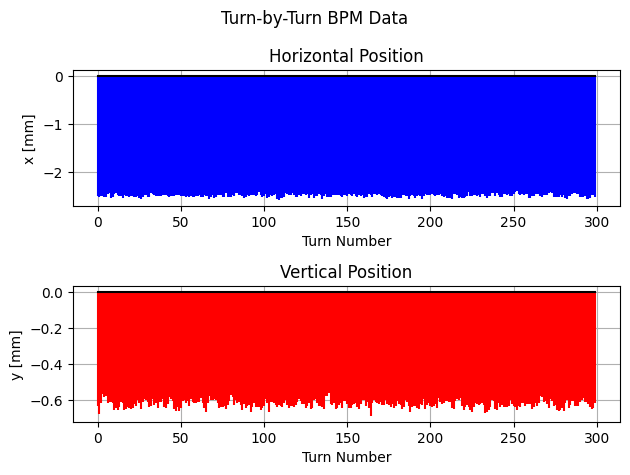

In [9]:
file_name = "test_tbt_data.hdf"
n_point   = 300
cut       = 108

tbt_bpm = tbt_bpm_class()

tbt_df = pd.read_hdf(file_name, key="df")
tbt_bpm.get_tbt_df(tbt_df, n_point, cut)

tbt_bpm.plt_tbt_data()